In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [62]:
# Load Data

data_path = '/Users/chenyihe/Desktop/Forecast exam part 2/mt_steel.csv'

steel_dat = pd.read_csv(data_path)

steel_dat.info()
print(steel_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXPORT  44 non-null     float64
 1   YEAR    44 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 836.0 bytes
    EXPORT  YEAR
0     3.89  1937
1     2.41  1938
2     2.80  1939
3     8.72  1940
4     7.12  1941
5     7.24  1942
6     7.15  1943
7     6.05  1944
8     5.21  1945
9     5.03  1946
10    6.88  1947
11    4.70  1948
12    5.06  1949
13    3.16  1950
14    3.62  1951
15    4.55  1952
16    2.43  1953
17    3.16  1954
18    4.55  1955
19    5.17  1956
20    6.95  1957
21    3.46  1958
22    2.13  1959
23    3.47  1960
24    2.79  1961
25    2.52  1962
26    2.80  1963
27    4.04  1964
28    3.08  1965
29    2.28  1966
30    2.17  1967
31    2.78  1968
32    5.94  1969
33    8.14  1970
34    3.55  1971
35    3.61  1972
36    5.06  1973
37    7.13  1974
38    4.15  1975
39    3.86  197

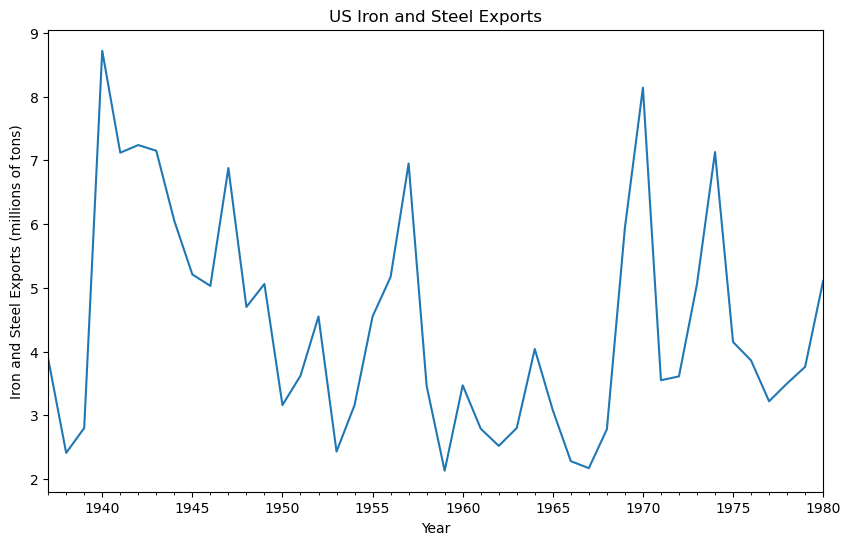

In [63]:
# Convert date column to a date class variable

steel_dat['YEAR'] = pd.to_datetime(steel_dat['YEAR'], format="%Y")

# Create indexed series


steel_ts = pd.Series(steel_dat['EXPORT'].values, index=steel_dat['YEAR'])


#Plot the series
plt.figure(figsize=(10, 6))
steel_ts.plot()
plt.title("US Iron and Steel Exports")
plt.xlabel("Year")
plt.ylabel("Iron and Steel Exports (millions of tons)")
plt.show()

In [64]:
#execute the Ljung Box test on the Steel series using 5 lags
EXPORTS = steel_dat[['EXPORT']]
sm.stats.acorr_ljungbox(EXPORTS, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,12.151048,0.032776


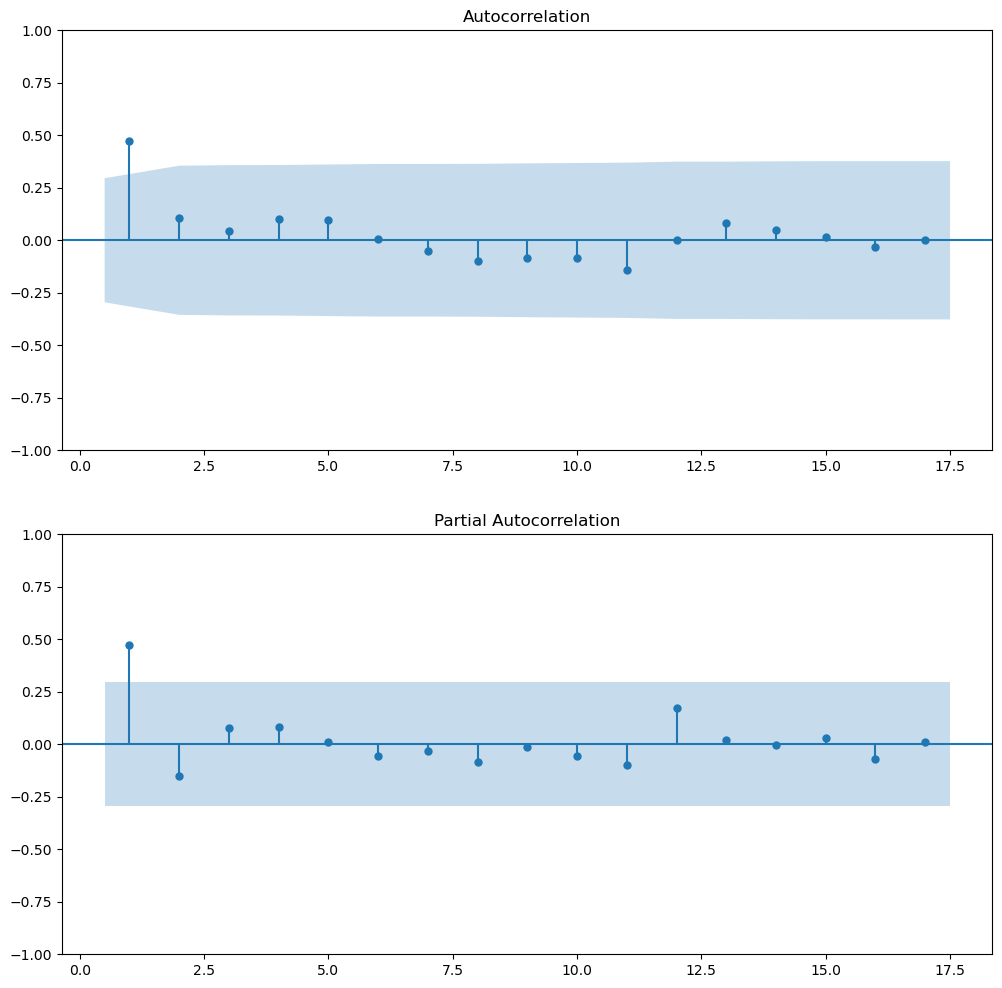

In [65]:
#Plot the ACF and PACF for the Steel series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(steel_ts, ax=ax1, zero=False)
plot_pacf(steel_ts, ax=ax2, zero=False)
plt.show()

Test Stationary

In [66]:
#Dickey Fuller (single mean version)
adfuller(steel_ts, regression='c')

(-3.8376521789007034,
 0.0025447423776594506,
 1,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 116.78753840925029)

Fit ARIMA(1,0,0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -81.186
Date:                Fri, 11 Oct 2024   AIC                            168.371
Time:                        17:58:31   BIC                            173.724
Sample:                    01-01-1937   HQIC                           170.356
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4213      0.554      7.975      0.000       3.335       5.508
ar.L1          0.4642      0.159      2.919      0.004       0.152       0.776
sigma2         2.3323      0.577      4.044      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


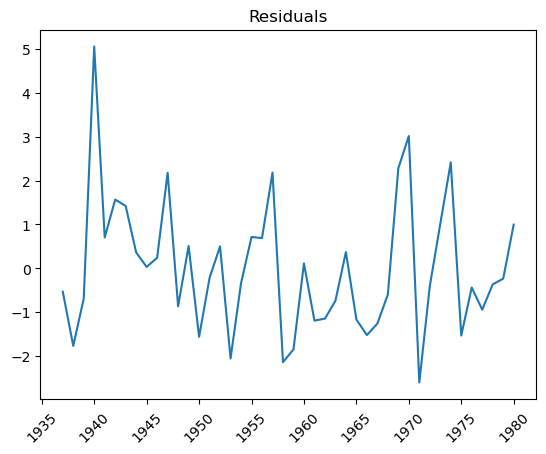

In [67]:
# Fit ARIMA(1,0,0) model to the data

fit_AR1 = ARIMA(steel_ts, order=(1,0,0)).fit()

# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)

ACF and PACF for ARIMA(1,0,0)

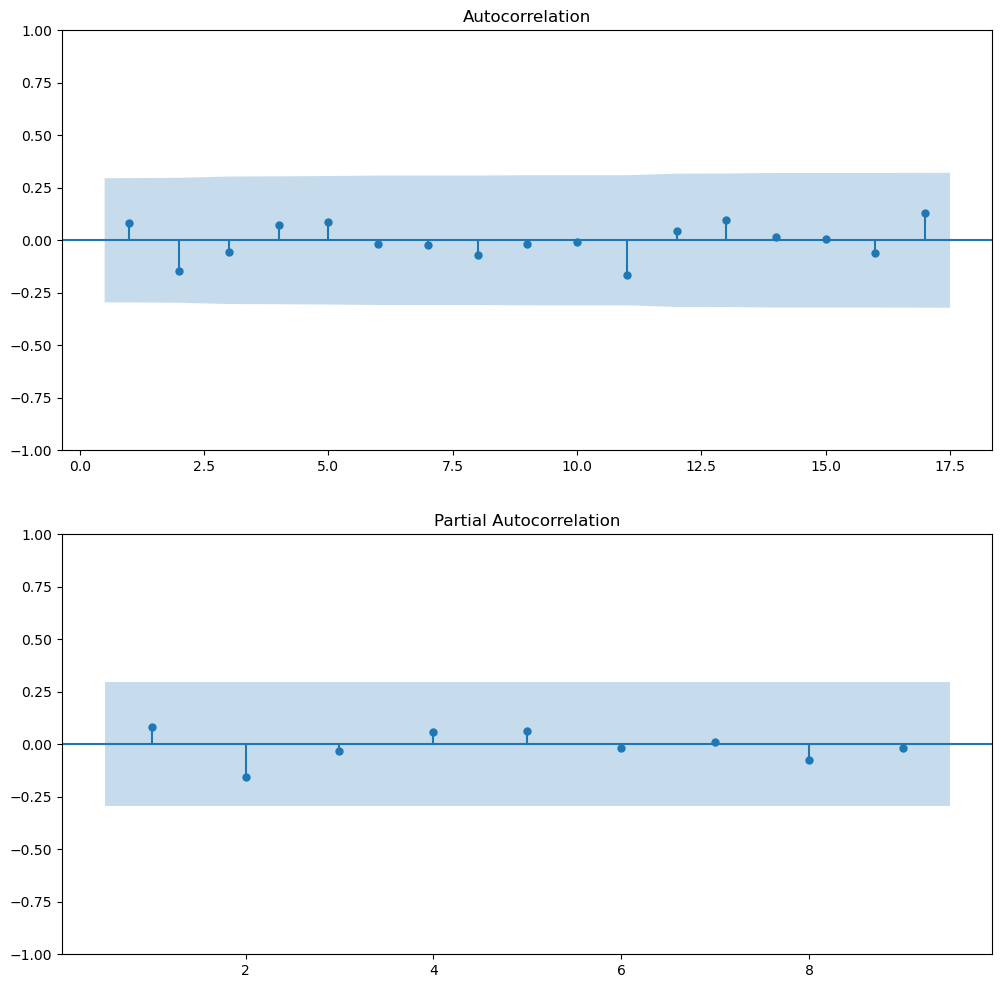

In [68]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()

Ljung Box Test for ARIMA(1,0,0)

In [69]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.509502,0.990737


Calculate MAPE and RMSE for ARIMA(1,0,0)

In [70]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
1937-01-01,4.421282,1.041937,7.800627
1938-01-01,4.174680,1.181428,7.167932
1939-01-01,3.487717,0.494465,6.480969
1940-01-01,3.668741,0.675489,6.661993
1941-01-01,6.416592,3.423340,9.409844


In [71]:
# add back actuals --
prediction_df = pd.concat([prediction_df,steel_ts.to_frame(name='export')],axis=1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,export
1937-01-01,4.421282,1.041937,7.800627,3.89
1938-01-01,4.174680,1.181428,7.167932,2.41
1939-01-01,3.487717,0.494465,6.480969,2.80
1940-01-01,3.668741,0.675489,6.661993,8.72
1941-01-01,6.416592,3.423340,9.409844,7.12


In [72]:
# calc error
errors = prediction_df['export'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['export'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')

MAPE = 29.548%
RMSE = 1.528


Fit AIRMA(1,0,1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -80.618
Date:                Fri, 11 Oct 2024   AIC                            169.236
Time:                        17:58:31   BIC                            176.373
Sample:                    01-01-1937   HQIC                           171.883
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4289      0.503      8.800      0.000       3.442       5.415
ar.L1          0.2244      0.312      0.719      0.472      -0.388       0.836
ma.L1          0.3193      0.327      0.977      0.3

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


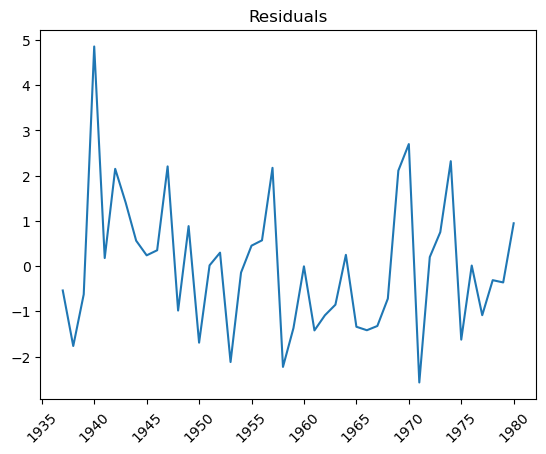

In [73]:
# Fit ARIMA(1,0,1) model to the data
fit_AR2 = ARIMA(steel_ts, order=(1,0,1)).fit()

# Summary of the ARIMA model
print(fit_AR2.summary())

# Examine residuals from the model
residuals = fit_AR2.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR2.get_prediction()
print(pred_units)

ACF and PACF for ARIMA(1,0,0)

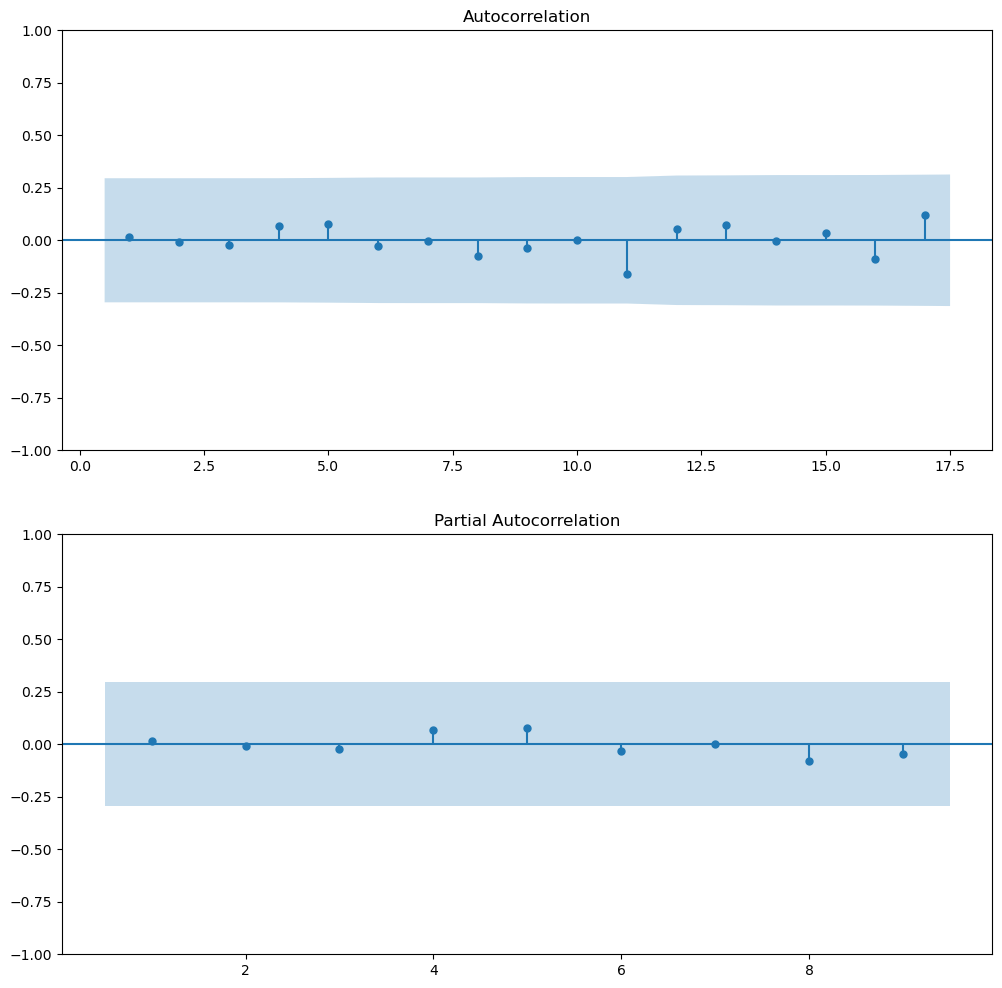

In [74]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()

Ljung Box test for ARIMA(1,0,1)

In [75]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,1.038854,0.999795


Calculate MAPE and RMES for ARIMA(1,0,1)

In [76]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
1937-01-01,4.428864,1.047343,7.810385
1938-01-01,4.176738,1.188185,7.165291
1939-01-01,3.425086,0.468498,6.381674
1940-01-01,3.864276,0.910881,6.817670
1941-01-01,6.941759,3.988689,9.894829


In [77]:
# add back actuals --
prediction_df = pd.concat([prediction_df,steel_ts.to_frame(name='export')],axis=1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,export
1937-01-01,4.428864,1.047343,7.810385,3.89
1938-01-01,4.176738,1.188185,7.165291,2.41
1939-01-01,3.425086,0.468498,6.381674,2.80
1940-01-01,3.864276,0.910881,6.817670,8.72
1941-01-01,6.941759,3.988689,9.894829,7.12


In [78]:
# calc error
errors = prediction_df['export'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['export'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')

MAPE = 28.850%
RMSE = 1.508


Forecast Based on ARIMA(1,0,0)

In [79]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=3)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_export': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_export,Lower_Bound,Upper_Bound
1981-01-01,4.740960,1.747708,7.734212
1982-01-01,4.569665,1.269683,7.869647
1983-01-01,4.490156,1.127752,7.852560


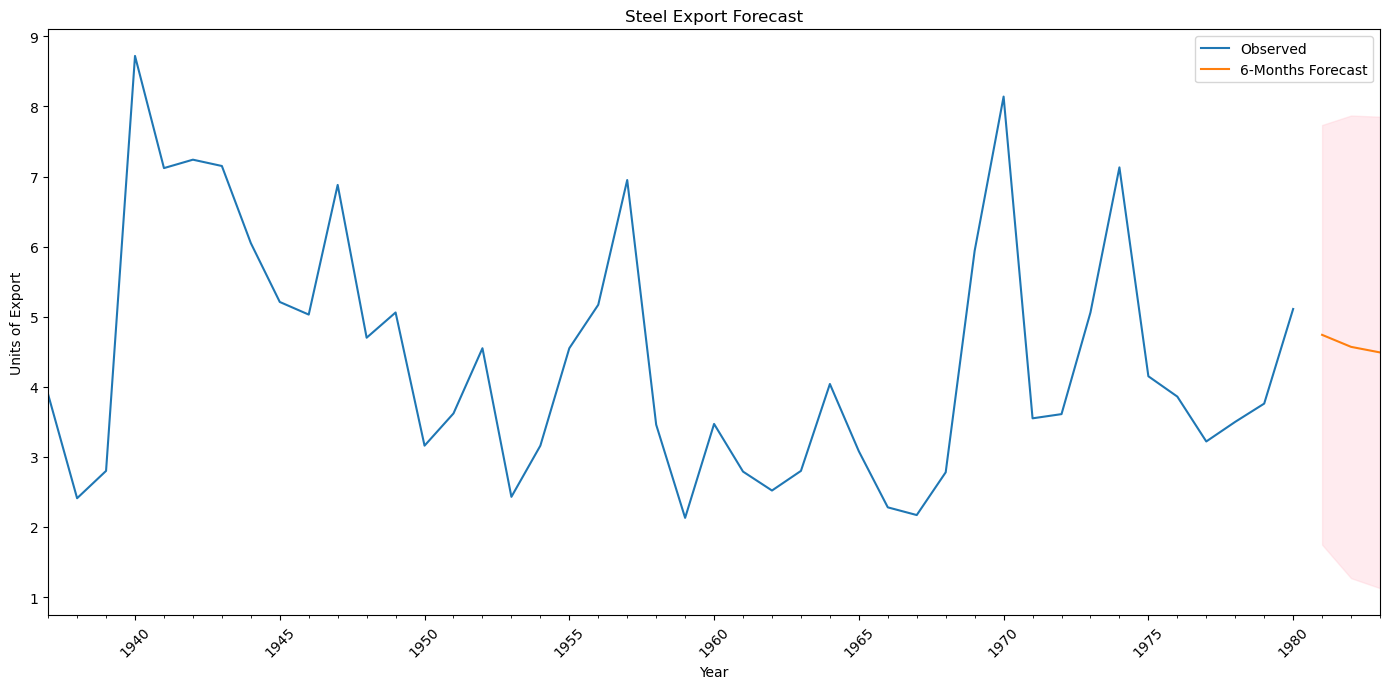

In [80]:

# Plot forecast
plt.figure(figsize=(14, 7))
steel_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Steel Export Forecast")
plt.xlabel("Year")
plt.ylabel("Units of Export")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()